In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd

from dotenv import load_dotenv
load_dotenv()
# DATASET_PATH=os.getenv("DATASET_DIRECTORY")
# DATASET_PATH="/data/RadVel"
DATASET_PATH = "/data/Hermes"
CONFIG_DIRECTORY = os.getenv("CONFIG_DIRECTORY")

sys.path.append("../")
from mmwave_radar_processing.config_managers.cfgManager import ConfigManager
from cpsl_datasets.cpsl_ds import CpslDS
from mmwave_radar_processing.processors.range_angle_resp import RangeAngleProcessor
from mmwave_radar_processing.processors.range_doppler_resp import RangeDopplerProcessor
from mmwave_radar_processing.processors.doppler_azimuth_resp import DopplerAzimuthProcessor
from mmwave_radar_processing.processors.micro_doppler_resp import MicroDopplerProcessor
from mmwave_radar_processing.processors.virtual_array_reformater import VirtualArrayReformatter
from mmwave_radar_processing.plotting.plotter_mmWave_data import PlotterMmWaveData
from mmwave_radar_processing.processors.altimeter import Altimeter
from mmwave_radar_processing.processors.velocity_estimator import VelocityEstimator
from mmwave_radar_processing.processors.range_resp import RangeProcessor
from mmwave_radar_processing.plotting.plotter_odometry_data import PlotterOdometryData
from mmwave_radar_processing.plotting.movies_odometry import MovieGeneratorOdometry

/home/david/.cache/pypoetry/virtualenvs/mmwave-radar-processing-ERvCMkmn-py3.12/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
cfg_manager = ConfigManager()

cfg_path = os.path.join(CONFIG_DIRECTORY,"1843_RadVel_10Hz_lr.cfg") #6843_RadVel_ods_20Hz or 1843_RadVel_20Hz
cfg_manager.load_cfg(cfg_path,
                     array_geometry="standard",
                     array_direction="out")  # "down" for downward sensing, "out" for outward sensing
cfg_manager.compute_radar_perforance(profile_idx=0)
print(f"Radar Range Resolution: {cfg_manager.range_res_m:.4f} m")

# dataset_name = "CPSL_RadVel_10Hz_lr_1"
dataset_name = "hermes_odom_test_1"
dataset_path = os.path.join(DATASET_PATH,dataset_name)
print(dataset_path)
# dataset_name = "RadSAR_2_CPSL"
# dataset_path = os.path.join(DATASET_PATH,os.pardir,"RadSAR",dataset_name)
dataset = CpslDS(
    dataset_path=dataset_path,
    radar_folder="front_radar_pc", #"radar_0_pc"
    lidar_folder="lidar",
    camera_folder="camera",
    imu_orientation_folder="imu_orientation", #not implemented
    imu_full_folder="imu_data",
    vehicle_vel_folder="vehicle_vel",
    vehicle_odom_folder="vehicle_odom"
)

Radar Range Resolution: 0.1366 m
/data/Hermes/hermes_odom_test_1
found 757 radar samples
found 757 lidar samples
did not find camera samples
did not find hand tracking samples
did not find imu (orientation) samples
did not find imu (full data) samples
found 757 vehicle velocity samples
found 757 vehicle odometry samples


In [3]:
plotter = PlotterOdometryData(config_manager=cfg_manager)

velocity_estimator = VelocityEstimator(
    config_manager=cfg_manager,
    lower_range_bound=0.1,
    upper_range_bound=0.5,
    precise_vel_bound=0.20,
    peak_threshold_dB=30.0,
    min_R2_threshold=0.20,
    min_inlier_percent=0.5
)

movie_generator = MovieGeneratorOdometry(
    cpsl_dataset=dataset,
    plotter=plotter,
    altimeter=None,
    velocity_estimator=velocity_estimator,
    virtual_array_reformatter=None,
    temp_dir_path="~/Downloads/velocity_estimation"
)

found temp dir: /home/david/Downloads/velocity_estimation
clearing temp directory /home/david/Downloads/velocity_estimation


 23%|██▎       | 174/757 [00:00<00:02, 203.14it/s]/home/david/.cache/pypoetry/virtualenvs/mmwave-radar-processing-ERvCMkmn-py3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
 38%|███▊      | 285/757 [00:01<00:01, 239.33it/s]/home/david/.cache/pypoetry/virtualenvs/mmwave-radar-processing-ERvCMkmn-py3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/david/.cache/pypoetry/virtualenvs/mmwave-radar-processing-ERvCMkmn-py3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
100%|██████████| 757/757 [00:03<00:00, 242.82it/s]


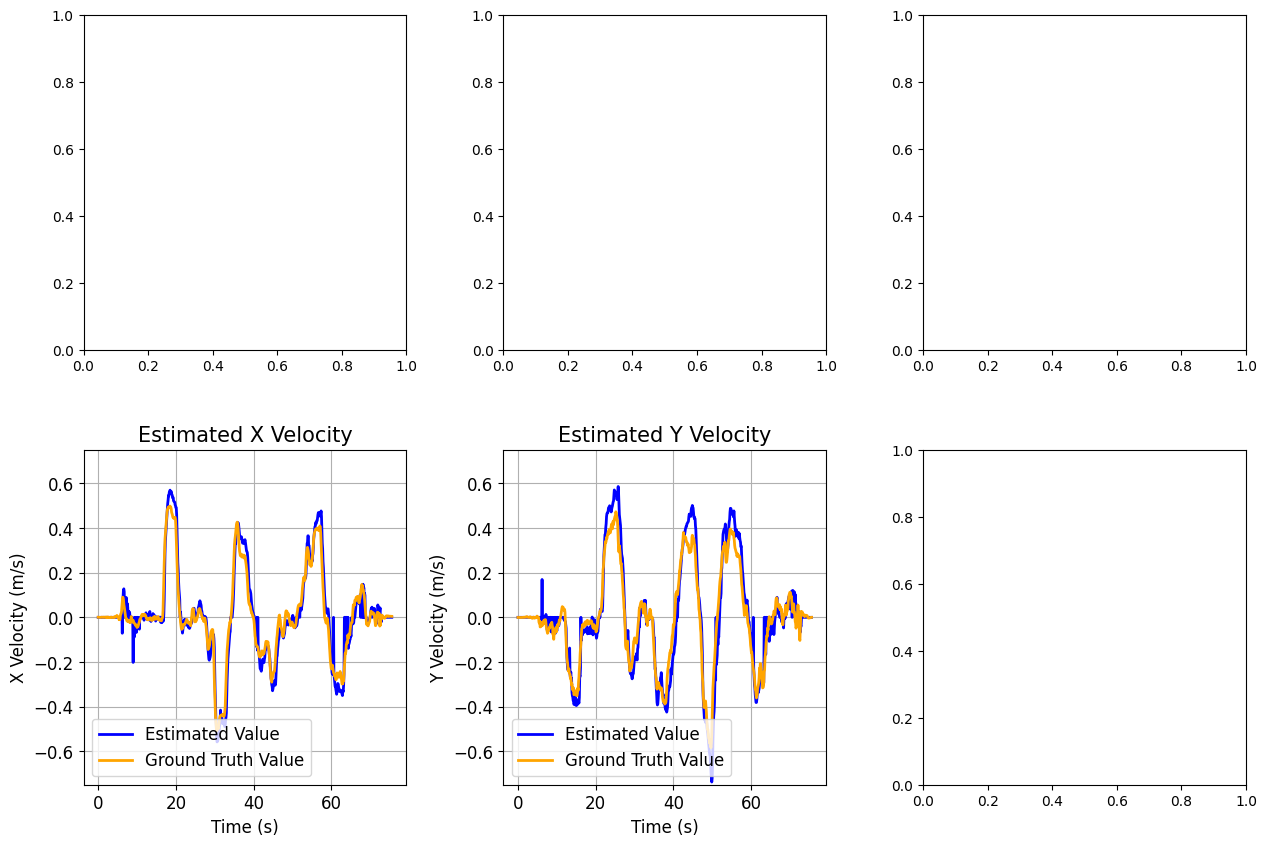

In [4]:
#for getting access to the adc cube
#good frames: 100 - takeoff 7- on ground 310 - moving
idx=dataset.num_frames#80#7#310#dataset.num_frames
velocity_estimator.reset()
hist_test = []
#compute responses over a series of frames
#get the ADC cube

for i in tqdm(range(idx)):
    radar_pts = dataset.get_radar_data(i)

    #save the altitude history
    vehicle_odom = dataset.get_vehicle_odom_data(idx=i)


    #estimate the velocity
    vel_est = velocity_estimator.process(
        points=radar_pts)
    
    #save the gt velocity history
    vehicle_vel_x = np.average(vehicle_odom[:,8])
    vehicle_vel_y = np.average(vehicle_odom[:,9])
    vehicle_vel_z = np.average(vehicle_odom[:,10])
    velocity_estimator.update_history(
        ground_truth=np.array([vehicle_vel_x,vehicle_vel_y,vehicle_vel_z]),
        estimated=vel_est
    )
    hist_test.append(vel_est)

    try:
        camera_view = dataset.get_camera_frame(i)
    except AssertionError:
        camera_view = np.empty(shape=(0))

plotter.plot_compilation(
    velocity_estimator=velocity_estimator,
    camera_view=camera_view,
    show=True
)

In [5]:
velocity_est_history = np.stack(velocity_estimator.history_estimated, axis=0)
velocity_gt_history = np.stack(velocity_estimator.history_gt, axis=0)

print(velocity_est_history.shape)
print(velocity_gt_history.shape)

(757, 3)
(757, 3)


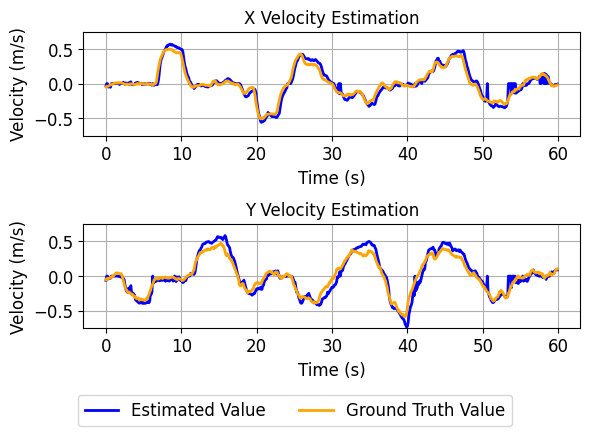

In [6]:
#comparing azimuth performance
vel_est = np.stack(velocity_estimator.history_estimated,axis=0)
vel_gt = np.stack(velocity_estimator.history_gt,axis=0)
inlier_stats = np.stack(velocity_estimator.history_R2_statistics,axis=0)
start_idx = 100
end_idx = 700#dataset.num_frames

fig, ax = plt.subplots(2, 1, figsize=(6, 4))

plotter.plot_estimated_vs_ground_truth(
    estimated=vel_est[start_idx:end_idx,0],
    ground_truth=vel_gt[start_idx:end_idx,0],
    value_label="X (Azimuth) Velocity (m/s)",
    ax=ax[0],
    frame_rate=10,
    show=False
)
ax[0].set_ylim([-0.75,0.75])
ax[0].set_ylabel("Velocity (m/s)",fontsize=plotter.font_size_axis_labels)
ax[0].set_title("X Velocity Estimation")
ax[0].legend().set_visible(False)

plotter.plot_estimated_vs_ground_truth(
    estimated=vel_est[start_idx:end_idx,1],
    ground_truth=vel_gt[start_idx:end_idx,1], #-1 * vel_gt[start_idx:end_idx,1],
    value_label="Y (Elevation) Velocity (m/s)",
    ax=ax[1],
    frame_rate=10,
    show=False
)
# Remove any existing legend from ax[1]
ax[1].legend().set_visible(False)
ax[1].set_ylim([-0.75, 0.75])
ax[1].set_ylabel("Velocity (m/s)", fontsize=plotter.font_size_axis_labels)
ax[1].set_title("Y Velocity Estimation")

# Move the legend outside the plot on the bottom left
handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), fontsize=plotter.font_size_axis_labels, ncol=len(labels))


# plotter.plot_estimated_vs_ground_truth(
#     estimated=vel_est[start_idx:end_idx,2],
#     ground_truth=-1 * vel_gt[start_idx:end_idx,2], #TODO: Fix this
#     value_label="Z Vertical Velocity (m/s)",
#     ax=ax[2],
#     show=False
# )
# ax[2].set_ylim([-0.75,0.75])

# ax.plot(residuals[:,1],label="Elevation Residuals")
plt.tight_layout()
# plt.legend()
plt.show()

Summary Statistics of Velocity Estimation Errors:
             Mean    Median      RMSE
X Error  0.043371  0.033779  0.057842
Y Error  0.062875  0.047594  0.080782
Z Error  0.044945  0.030818  0.072370
Norm     0.106599  0.091475  0.122918




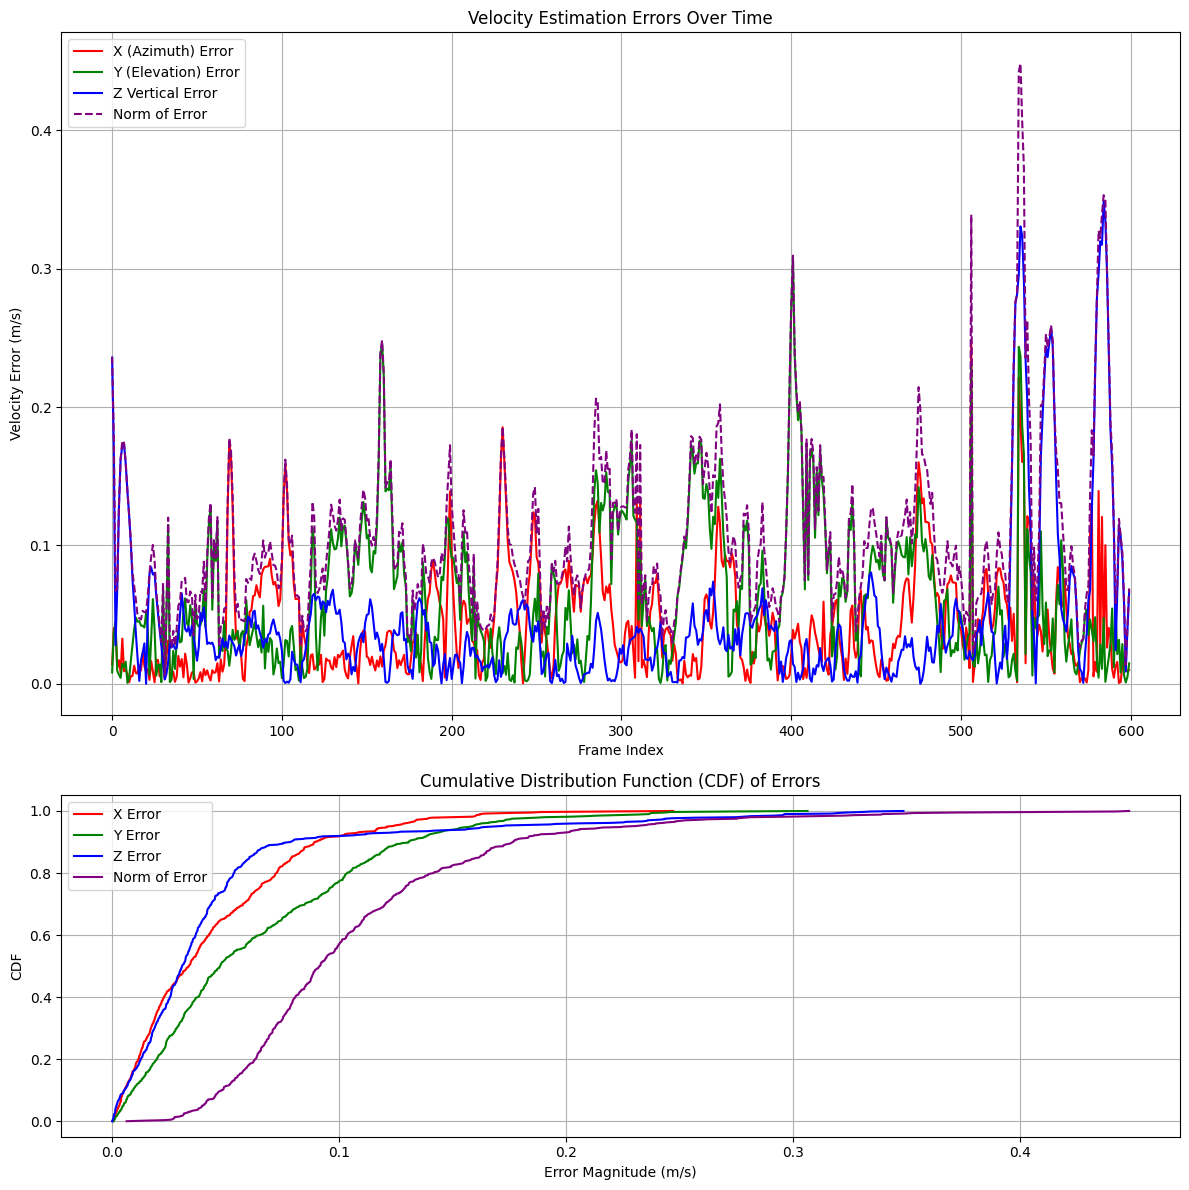

In [7]:
vel_est = np.stack(velocity_estimator.history_estimated, axis=0)
vel_gt = np.stack(velocity_estimator.history_gt, axis=0)

x_errors = np.abs(vel_est[start_idx:end_idx, 0] - vel_gt[start_idx:end_idx, 0])
y_errors = np.abs(vel_est[start_idx:end_idx, 1] - vel_gt[start_idx:end_idx, 1]) #TODO: Account for different coordinate frame
z_errors = np.abs(vel_est[start_idx:end_idx, 2] - -1 * vel_gt[start_idx:end_idx, 2])  # TODO: Fix this

# Compute the norm of the velocity error
norm_errors = np.sqrt(x_errors**2 + y_errors**2 + z_errors**2)

# Calculate summary statistics using pandas
errors_df = pd.DataFrame({
    "X Error": x_errors,
    "Y Error": y_errors,
    "Z Error": z_errors,
    "Norm": norm_errors
})

summary_stats = pd.DataFrame({
    "Mean": errors_df.mean(),
    "Median": errors_df.median(),
    "RMSE": np.sqrt((errors_df ** 2).mean())
})

print("Summary Statistics of Velocity Estimation Errors:")
print(summary_stats.to_string())
print("\n")

fig, axs = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [2, 1]})

# Plot errors over time
axs[0].plot(x_errors, label="X (Azimuth) Error", color="red")
axs[0].plot(y_errors, label="Y (Elevation) Error", color="green")
axs[0].plot(z_errors, label="Z Vertical Error", color="blue")
axs[0].plot(norm_errors, label="Norm of Error", color="purple", linestyle="--")
axs[0].set_xlabel("Frame Index")
axs[0].set_ylabel("Velocity Error (m/s)")
axs[0].set_title("Velocity Estimation Errors Over Time")
axs[0].legend()
axs[0].grid(True)

# Plot CDF for errors
for errors, label, color in zip(
    [x_errors, y_errors, z_errors, norm_errors],
    ["X Error", "Y Error", "Z Error", "Norm of Error"],
    ["red", "green", "blue", "purple"]
):
    sorted_errors = np.sort(errors)
    cdf = np.linspace(0, 1, len(sorted_errors))
    axs[1].plot(sorted_errors, cdf, label=label, color=color)

axs[1].set_xlabel("Error Magnitude (m/s)")
axs[1].set_ylabel("CDF")
axs[1].set_title("Cumulative Distribution Function (CDF) of Errors")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

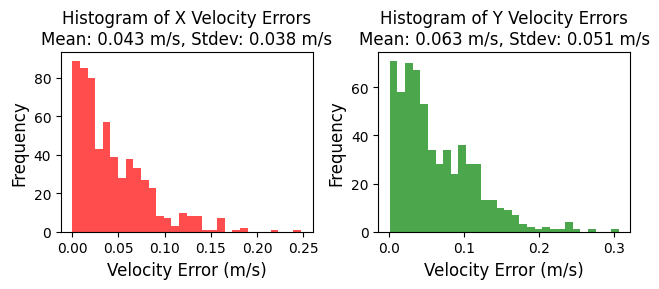

In [8]:
vel_est = np.stack(velocity_estimator.history_estimated,axis=0)
vel_gt = np.stack(velocity_estimator.history_gt,axis=0)

x_errors = np.abs(vel_est[start_idx:end_idx,0] - vel_gt[start_idx:end_idx,0])
y_errors = np.abs(vel_est[start_idx:end_idx,1] - vel_gt[start_idx:end_idx,1])
z_errors = np.abs(vel_est[start_idx:end_idx,2] - -1 * vel_gt[start_idx:end_idx,2]) #TODO: Fix this

fig, axs = plt.subplots(1, 2, figsize=(6.5, 3))

# Calculate mean and variance for X errors
x_mean = np.mean(x_errors)
x_variance = np.std(x_errors)
axs[0].hist(x_errors, bins=30, color='red', alpha=0.7)
axs[0].set_xlabel("Velocity Error (m/s)",fontsize=plotter.font_size_axis_labels)
axs[0].set_ylabel("Frequency",fontsize=plotter.font_size_axis_labels)
axs[0].set_title(f"Histogram of X Velocity Errors\nMean: {x_mean:.3f} m/s, Stdev: {x_variance:.3f} m/s",fontsize=plotter.font_size_axis_labels)

# Calculate mean and variance for Y errors
y_mean = np.mean(y_errors)
y_variance = np.std(y_errors)
axs[1].hist(y_errors, bins=30, color='green', alpha=0.7)
axs[1].set_xlabel("Velocity Error (m/s)",fontsize=plotter.font_size_axis_labels)
axs[1].set_ylabel("Frequency",fontsize=plotter.font_size_axis_labels)
axs[1].set_title(f"Histogram of Y Velocity Errors\nMean: {y_mean:.3f} m/s, Stdev: {y_variance:.3f} m/s",fontsize=plotter.font_size_axis_labels)

# Calculate mean and variance for Z errors
# z_mean = np.mean(z_errors)
# z_variance = np.var(z_errors)
# axs[2].hist(z_errors, bins=30, color='blue', alpha=0.7)
# axs[2].set_xlabel("Z Vertical Error (m/s)")
# axs[2].set_ylabel("Frequency")
# axs[2].set_title(f"Histogram of Z Velocity Errors\nMean: {z_mean:.3f}, Variance: {z_variance:.3f}")

plt.tight_layout()
plt.show()

(0.0, 1.0)

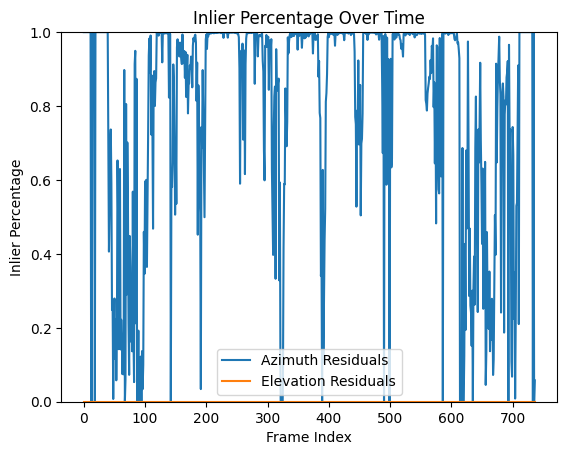

In [9]:
inlier_stats = np.stack(velocity_estimator.history_R2_statistics,axis=0)
plt.plot(inlier_stats[20:,0],label="Azimuth Residuals")
plt.plot(inlier_stats[20:,1],label="Elevation Residuals")
plt.legend()
plt.xlabel("Frame Index")
plt.ylabel("Inlier Percentage")
plt.title("Inlier Percentage Over Time")
plt.ylim([0.0,1])

(-1.0, 1.0)

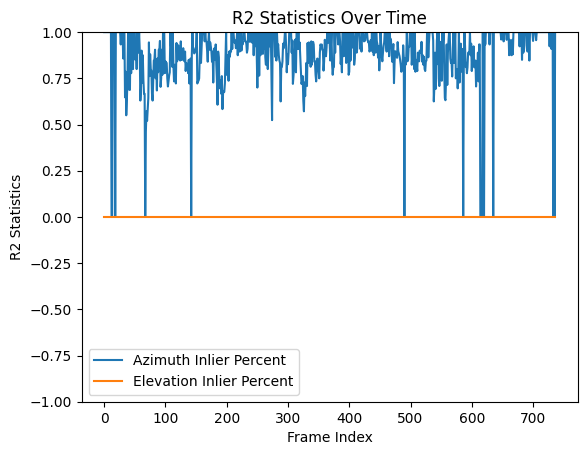

In [10]:
inlier_stats = np.stack(velocity_estimator.history_inlier_statistics,axis=0)
plt.plot(inlier_stats[20:,0],label="Azimuth Inlier Percent")
plt.plot(inlier_stats[20:,1],label="Elevation Inlier Percent")
plt.legend()
plt.xlabel("Frame Index")
plt.ylabel("R2 Statistics")
plt.title("R2 Statistics Over Time")
plt.ylim([-1,1])

 15%|█▍        | 98/657 [00:21<02:02,  4.56it/s]/home/david/.cache/pypoetry/virtualenvs/mmwave-radar-processing-ERvCMkmn-py3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
 29%|██▉       | 193/657 [00:42<01:43,  4.46it/s]/home/david/.cache/pypoetry/virtualenvs/mmwave-radar-processing-ERvCMkmn-py3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/david/.cache/pypoetry/virtualenvs/mmwave-radar-processing-ERvCMkmn-py3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
100%|██████████| 657/657 [00:30<00:00, 21.43it/s]


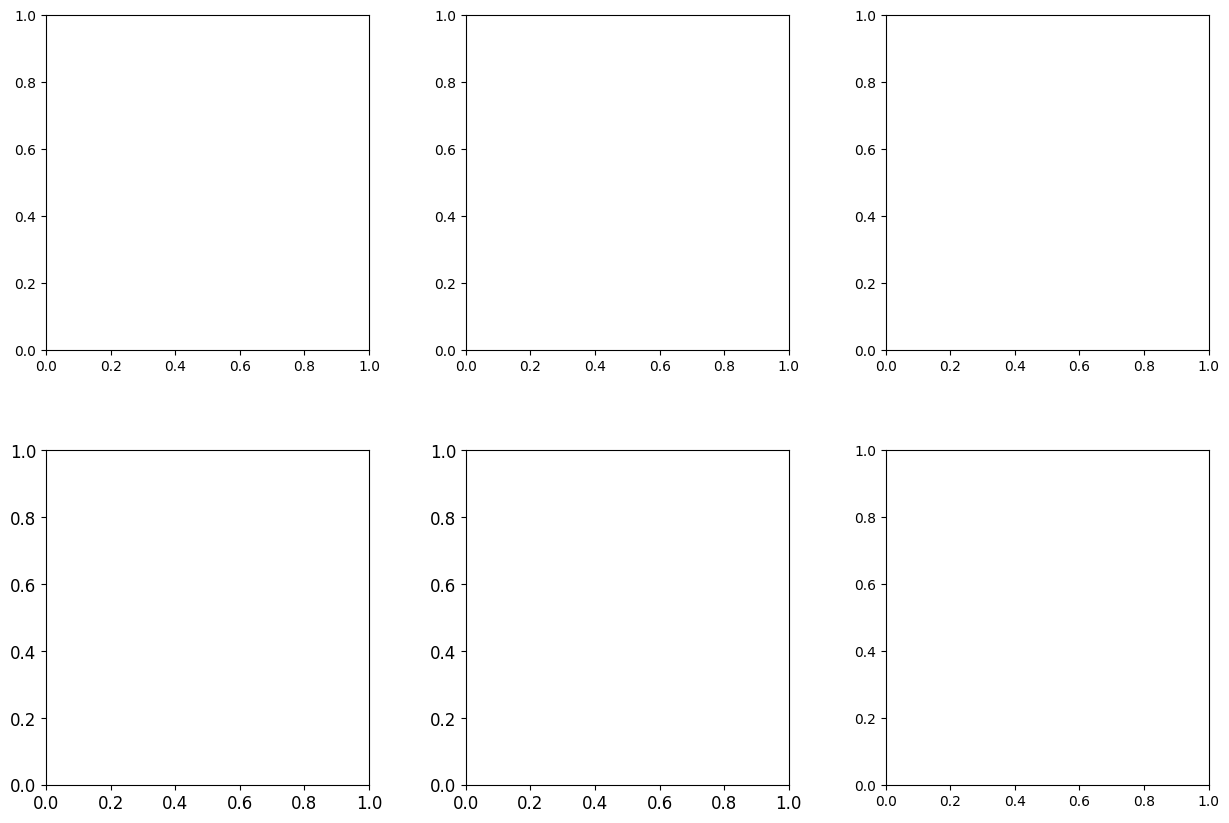

In [11]:
#generate the movie
movie_generator.initialize_figure(nrows=2,ncols=3,figsize=(15,10))
velocity_estimator.reset()

movie_generator.generate_movie_frames(
    cmap="viridis",
    convert_to_dB=True,
    start_idx=100,
)

fps = 1 / (1e-3 * cfg_manager.frameCfg_periodicity_ms)
movie_generator.save_movie(video_file_name="{}_velocity_est.mp4".format(dataset_name),fps=fps)